In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
dir = f'C:/Users/fitzpatrick/Desktop/Data/'

## Read in PCP data from CFSR
data_1 = pd.read_csv(dir+'2020/CFS_APCP_Basin_Avgs.csv',sep=',')
month = data_1['month']
su_pcp = data_1['WaterSuperior']
er_pcp = data_1['WaterErie']
on_pcp = data_1['WaterOntario']
mh_pcp = data_1['WaterMichigan']+data_1['WaterHuron']

## Read in EVAP data from CFSR
data_2 = pd.read_csv(dir+'2020/CFS_EVAP_Basin_Avgs.csv',sep=',')
su_evap = data_2['WaterSuperior']
er_evap = data_2['WaterErie']
on_evap = data_2['WaterOntario']
mh_evap = data_2['WaterMichigan']+data_2['WaterHuron']

## Read in TMP data from CFSR
data_3 = pd.read_csv(dir+'2020/CFS_TMP_Basin_Avgs.csv',sep=',')
su_tmp = data_3['WaterSuperior']
er_tmp = data_3['WaterErie']
on_tmp = data_3['WaterOntario']
mh_tmp = data_3['WaterMichigan']+data_3['WaterHuron']

model = tf.keras.models.load_model(dir+'Input/NN_trained_model.keras')

In [38]:
# Read in GLCC RNBS data
data_4 = pd.read_csv(dir + 'Input/rnbs_glcc.csv', sep=',')

# Ensure 'Date' column is treated as string and modified as necessary
date_strs = data_4['Date'].astype(str)

date_rnbs = []

for date_str in date_strs:
    # Insert leading zero before month (if necessary)
    if len(date_str) == 6:
        date_str = date_str[:4] + '0' + date_str[4:]

    # Insert leading zero before day (if necessary)
    if len(date_str) == 7:
        date_str = date_str[:6] + '0' + date_str[6:]

    # Convert to datetime object
    datetime_obj = datetime.strptime(date_str, '%Y%m%d')

    # Format the datetime object as a string in the desired format
    date_tmp = datetime_obj.strftime('%Y-%m-%d')

    # Append formatted date to list
    date_rnbs.append(date_tmp)

# Replace the original 'Date' column with formatted dates
data_4['Date'] = date_rnbs

# Convert 'Date' column to datetime format
data_4['Date'] = pd.to_datetime(data_4['Date'])

# Add a new column 'Month' extracting month from 'Date'
data_4['Month'] = data_4['Date'].dt.month

# Select only the data that matches with the CFSR dates
start_date = '2020-01-01'
end_date = '2020-12-01'
selected_data = data_4[(data_4['Date'] >= start_date) & (data_4['Date'] <= end_date)]

su_rnbs = selected_data['sup']
er_rnbs = selected_data['eri']
on_rnbs = selected_data['ont']
mh_rnbs = selected_data['mic_hur']

In [6]:
X = pd.DataFrame({
    'su_pcp': su_pcp,
    'er_pcp': er_pcp,
    'on_pcp': on_pcp,
    'mh_pcp': mh_pcp,
    'su_evap': su_evap,
    'er_evap': er_evap,
    'on_evap': on_evap,
    'mh_evap': mh_evap,
    'su_tmp': su_tmp,
    'er_tmp': er_tmp,
    'on_tmp': on_tmp,
    'mh_tmp': mh_tmp
})

# Merge on 'Month'
X = pd.concat([X, pd.get_dummies(month, prefix='Month')], axis=1)

# Drop any rows with NaN values (if any)
X.dropna(inplace=True)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Predict on the test set
y_pred = model.predict(X_scaled)

437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


In [25]:
month_var = month.values
month_2d = month_var.reshape(-1, 1)
combined_data = np.hstack((month_2d, y_pred))
df = pd.DataFrame(combined_data, columns=['Month', 'Superior', 'Erie', 'Ontario', 'Mich-Huron'])
print(df)

[[  1.          32.09056091 137.4485321  193.09921265  79.47582245]
 [  2.           9.06573486 128.91963196 166.9974823   58.79326248]
 [  3.          31.67118835 305.59518433 404.54238892 147.38922119]
 ...
 [  7.          86.92621613  11.2289505   60.57548141  59.71490097]
 [  8.          69.39592743  16.67323112  56.05254745  51.39211655]
 [  9.         120.22491455  47.92650986 119.25507355  99.69957733]]
       Month    Superior        Erie     Ontario  Mich-Huron
0        1.0   32.090561  137.448532  193.099213   79.475822
1        2.0    9.065735  128.919632  166.997482   58.793262
2        3.0   31.671188  305.595184  404.542389  147.389221
3        4.0  102.456093  142.103134  238.000763  132.311432
4        5.0   92.231941   54.740185  106.364586   86.046715
...      ...         ...         ...         ...         ...
13955    5.0   65.041695   20.717363   56.994465   52.361450
13956    6.0   82.009666   47.032749   95.028481   75.396774
13957    7.0   86.926216   11.228951 

In [29]:
def mean_min_max(df,lake):
    mean = df.groupby('Month')[lake].mean()
    min = df.groupby('Month')[lake].min()
    max = df.groupby('Month')[lake].max()

    return mean, min, max

mean_er, min_er, max_er = mean_min_max(df, 'Erie')
mean_su, min_su, max_su = mean_min_max(df, 'Superior')
mean_on, min_on, max_on = mean_min_max(df, 'Ontario')
mean_mh, min_mh, max_mh = mean_min_max(df, 'Mich-Huron')

print(mean_er)

Month
1.0     147.919066
2.0     154.835442
3.0     215.150610
4.0     172.795996
5.0      87.523119
6.0      42.590936
7.0       9.382964
8.0      -6.393462
9.0      10.894796
10.0     27.067373
11.0     75.090920
12.0    158.572205
Name: Erie, dtype: float64


In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate Mean Squared Error
mse = mean_squared_error(er_rnbs, mean_er)
r_squared = r2_score(er_rnbs, mean_er)
print(f"The r squared value for the model is {r_squared}")
print(f"Mean Squared Error: {mse}")

The r squared value for the model is 0.4137652819953823
Mean Squared Error: 7257.314999275785


C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_13068\1718921843.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[3].set_xticklabels(['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov'])


[Text(0.0, 0, 'Jan'),
 Text(2.0, 0, 'Mar'),
 Text(4.0, 0, 'May'),
 Text(6.0, 0, 'Jul'),
 Text(8.0, 0, 'Sep'),
 Text(10.0, 0, 'Nov'),
 Text(12.0, 0, '')]

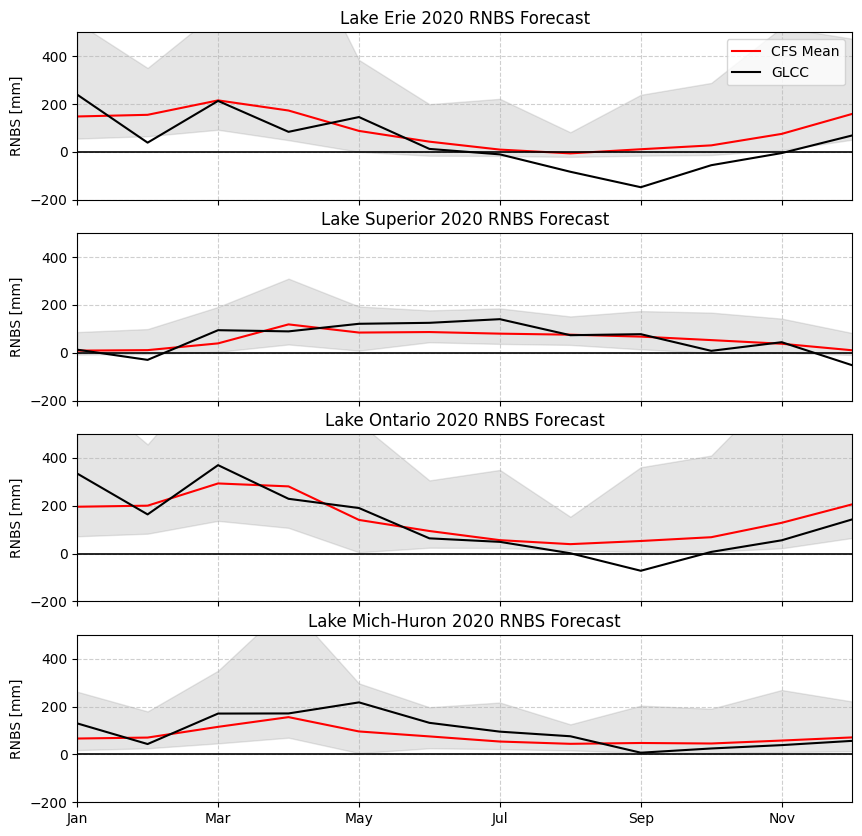

In [44]:
x_values = np.arange(12)  # Assuming x-axis represents months from 1 to 12

# Creating a 4x1 grid of subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True, sharey=True)

axs[0].plot(x_values, mean_er, color='red', linestyle='-', linewidth=1.5, label='CFS Mean')
axs[0].plot(x_values, er_rnbs, color='black', linestyle='-', linewidth=1.5, label='GLCC')
axs[0].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[0].fill_between(x_values, min_er, max_er, color='gray', alpha=0.2)
axs[0].set_ylabel('RNBS [mm]')
axs[0].set_title('Lake Erie 2020 RNBS Forecast')
axs[0].set_ylim(-200, 500)
axs[0].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[0].legend(loc='upper right')
axs[0].grid(True, linestyle='--', alpha=0.6)

axs[1].plot(x_values, mean_su, color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[1].plot(x_values, su_rnbs, color='black', linestyle='-', linewidth=1.5, label='Mean')
axs[1].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[1].fill_between(x_values, min_su, max_su, color='gray', alpha=0.2)
axs[1].set_ylabel('RNBS [mm]')
axs[1].set_title('Lake Superior 2020 RNBS Forecast')
axs[1].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[1].grid(True, linestyle='--', alpha=0.6)

axs[2].plot(x_values, mean_on, color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[2].plot(x_values, on_rnbs, color='black', linestyle='-', linewidth=1.5, label='Mean')
axs[2].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[2].fill_between(x_values, min_on, max_on, color='gray', alpha=0.2)
axs[2].set_ylabel('RNBS [mm]')
axs[2].set_title('Lake Ontario 2020 RNBS Forecast')
axs[2].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[2].grid(True, linestyle='--', alpha=0.6)

axs[3].plot(x_values, mean_mh, color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[3].plot(x_values, mh_rnbs, color='black', linestyle='-', linewidth=1.5, label='Mean')
axs[3].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[3].fill_between(x_values, min_mh, max_mh, color='gray', alpha=0.2)
axs[3].set_ylabel('RNBS [mm]')
axs[3].set_title('Lake Mich-Huron 2020 RNBS Forecast')
axs[3].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[3].grid(True, linestyle='--', alpha=0.6)
axs[3].set_xticklabels(['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov'])
